In [34]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import zipfile
import io
import torch.optim as op
import torch.nn.functional as F




# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [5]:
!unzip lfw.zip
path = '/content/lfw'






Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

In [6]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


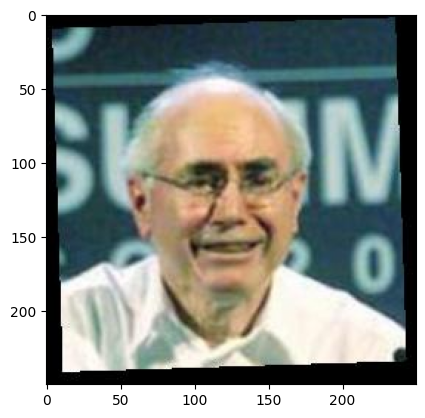

In [8]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [35]:
import torch
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(16)
        self.encoder_relu1 = nn.ReLU()
        self.encoder_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(32)
        self.encoder_relu2 = nn.ReLU()
        self.encoder_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder layers
        self.decoder_conv1 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.decoder_bn1 = nn.BatchNorm2d(16)
        self.decoder_relu1 = nn.ReLU()
        self.decoder_upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.decoder_conv2 = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1)
        self.decoder_bn2 = nn.BatchNorm2d(1)
        self.decoder_relu2 = nn.ReLU()
        self.decoder_upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def encoder(self, x):
        x = self.encoder_conv1(x)
        x = self.encoder_bn1(x)
        x = self.encoder_relu1(x)
        x = self.encoder_pool1(x)

        x = self.encoder_conv2(x)
        x = self.encoder_bn2(x)
        x = self.encoder_relu2(x)
        x = self.encoder_pool2(x)

        return x

    def decoder(self, x):
        x = self.decoder_conv1(x)
        x = self.decoder_bn1(x)
        x = self.decoder_relu1(x)
        x = self.decoder_upsample1(x)

        x = self.decoder_conv2(x)
        x = self.decoder_bn2(x)
        x = self.decoder_relu2(x)
        x = self.decoder_upsample2(x)

        return x

    def forward(self, x):
        encoded = self.encoder(x)
        print("Encode shape", encoded.shape)
        decoded = self.decoder(encoded)
        print("Decoded shape", decoded.shape)
        return decoded


Encode shape torch.Size([1, 32, 7, 7])
Decoded shape torch.Size([1, 1, 28, 28])
Input size: torch.Size([1, 1, 28, 28])
Output size: torch.Size([1, 1, 28, 28])


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [51]:
# Define the transformation
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

# Create a DataLoader
dataloader = DataLoader(ImageFolder(path, transform), batch_size=32, shuffle=True)

# Create an instance of the AE class
autoencoder = AE()

# Iterate through the DataLoader
for x, y in dataloader:
    # Assuming 'x' is your input image tensor
    print("Input shape:", x.shape)

    # Forward pass through the model
    encoded_output = autoencoder.encoder(x)
    decoded_output = autoencoder.decoder(encoded_output)

    # Print the shapes of the encoder and decoder outputs
    print("Encoder output shape:", encoded_output.shape)
    print("Decoder output shape:", decoded_output.shape)

Input shape: torch.Size([32, 1, 250, 250])
Encoder output shape: torch.Size([32, 32, 62, 62])
Decoder output shape: torch.Size([32, 1, 248, 248])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [25]:
total_params = sum(p.numel() for p in autoencoder.parameters())
print(f'Total parameters: {total_params}')
learning_rate = 0.001

Total parameters: 9699


In [26]:
optim = op.Adam(autoencoder.parameters(), lr = learning_rate)

In [27]:
loss_function =torch.nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [39]:
# Set the number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0

    for x, _ in dataloader:
        # Forward pass
        output = autoencoder(x)

        # Resized for sizing issues with autoencoder
        resize = F.interpolate(x, size=(output.size(2), output.size(3)), mode='bilinear', align_corners=False)

        # Calculate the loss
        loss = loss_function(output, resize)

        # Backward pass and optimization
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()

    # Calculate and print the average loss for the epoch
    average_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss}')

    # Break early if the loss is not decreasing
    if epoch > 0 and average_loss >= prev_loss:
        print("Loss is not decreasing. Stopping training.")
        break

    # Update the previous loss for the next epoch
    prev_loss = average_loss

Encode shape torch.Size([32, 32, 62, 62])
Decoded shape torch.Size([32, 1, 248, 248])
Encode shape torch.Size([32, 32, 62, 62])
Decoded shape torch.Size([32, 1, 248, 248])
Encode shape torch.Size([32, 32, 62, 62])
Decoded shape torch.Size([32, 1, 248, 248])
Encode shape torch.Size([32, 32, 62, 62])
Decoded shape torch.Size([32, 1, 248, 248])
Encode shape torch.Size([32, 32, 62, 62])
Decoded shape torch.Size([32, 1, 248, 248])
Encode shape torch.Size([32, 32, 62, 62])
Decoded shape torch.Size([32, 1, 248, 248])
Encode shape torch.Size([32, 32, 62, 62])
Decoded shape torch.Size([32, 1, 248, 248])
Encode shape torch.Size([32, 32, 62, 62])
Decoded shape torch.Size([32, 1, 248, 248])
Encode shape torch.Size([32, 32, 62, 62])
Decoded shape torch.Size([32, 1, 248, 248])
Encode shape torch.Size([32, 32, 62, 62])
Decoded shape torch.Size([32, 1, 248, 248])
Encode shape torch.Size([32, 32, 62, 62])
Decoded shape torch.Size([32, 1, 248, 248])
Encode shape torch.Size([32, 32, 62, 62])
Decoded shap

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

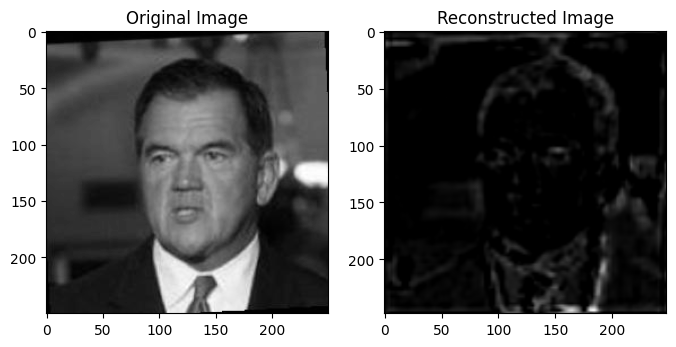

In [48]:
data_iter = iter(dataloader)
images, _ = next(data_iter)  # Get a batch of images
random_image = images[0].unsqueeze(0)  # Take the first image from the batch

# Forward pass through the autoencoder
with torch.no_grad():
    encoded_output = autoencoder.encoder(random_image)
    reconstructed_output = autoencoder.decoder(encoded_output)

# Convert tensors to numpy arrays for plotting
random_image_np = random_image.squeeze().numpy()
reconstructed_image_np = reconstructed_output.squeeze().numpy()

# Plot the original and reconstructed images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(random_image_np, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_np, cmap='gray')
plt.title('Reconstructed Image')

plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

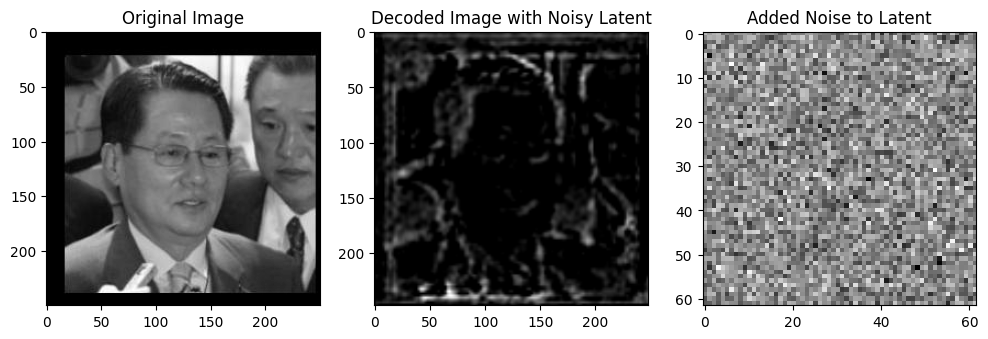

In [50]:
# Convert tensors to numpy arrays for plotting
random_image_np = random_image.squeeze().numpy()  # Remove any singleton dimensions
decoded_image_noisy_np = decoded_output_noisy.squeeze().numpy()  # Remove any singleton dimensions

# Plot the original and reconstructed (noisy) images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(random_image_np, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(decoded_image_noisy_np, cmap='gray')
plt.title('Decoded Image with Noisy Latent')

plt.subplot(1, 3, 3)
plt.imshow(noise.squeeze().numpy()[0], cmap='gray')  # Visualize the added noise
plt.title('Added Noise to Latent')

plt.show()
